In [ ]:
import json
import os
import pprint
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math

class digest_query:
    def __init__(self, query_id, digest, digest_text, time_ms, cpu_usage, timestamp):
        self.query_id = query_id
        self.digest = digest
        self.digest_text = digest_text
        self.value = [(timestamp, time_ms, cpu_usage)]
        self.time_ms = []
        self.cpu_usage = []
        self.timestamp = []
    
    def add_timestamp(self, time_ms, cpu_usage, timestamp):
        self.value.append((timestamp, time_ms, cpu_usage))
    
    def print_digest_query(self):
        print(f'query_id={self.query_id}')
        print(f'digest={self.digest}')
        print(f'digest_text={self.digest_text}')
        print(f'time_ms={self.time_ms}')
        print(f'cpu_usage={self.cpu_usage}')
    
    def sort_timestamp(self):
        self.value = list(map(lambda x: (x[0], float(x[1]), float(x[2])), self.value))
        self.value = sorted(self.value, key=lambda x:x[0])
        for v in self.value:
            self.time_ms.append(v[1]) 
            self.cpu_usage.append(v[2])
            self.timestamp.append(v[0])
    
    def add_missing_value(self, all_timestamp):
        new_time_ms = []
        new_cpu_usage = []
        #print(all_timestamp)
        #print(self.timestamp)
        for time in all_timestamp:
            if time in self.timestamp: #b에서 val의 index
                new_time_ms.append(self.time_ms[self.timestamp.index(time)])
                new_cpu_usage.append(self.time_ms[self.timestamp.index(time)])
            else:
                new_time_ms.append(0)
                new_cpu_usage.append(0)
        #print(len(all_timestamp), len(new_time_ms), len(new_cpu_usage))
        self.time_ms = new_time_ms
        self.cpu_usage = new_cpu_usage


def import_data(path):
    dict = {}
    query_num = 0
    all_timestamp =[]

    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r') as f:
            file_datetime = dt.datetime.strptime(filename,'%Y%m%d_%H%M%S') 
            all_timestamp.append(file_datetime)
            text = json.load(f)
            #io = text['metrics_data']["global"]["engine"]["innodb_status_io"]
            performance_schema = text['metrics_data']['global']['performance_schema']
            threads = performance_schema['threads']       
            tid_dict = {i[0]['thread_id']:i[0]['thread_os_id'] for i in threads}
            cpu_usage = performance_schema['cpu_usage'] # thread_os_id : cpu_usage
            events_statements_history = performance_schema['events_statements_history']
            #break
            for event in events_statements_history:
                digest = event['digest']
                if digest is None:
                    continue
                #print(type(digest))
                thread_id = event['thread_id']
                digest_text = event['digest_text']
                if digest in dict.keys():
                    dict[digest].add_timestamp(event['time_ms'], cpu_usage[str(tid_dict[thread_id])], file_datetime)
                else:
                    temp = digest_query(query_num, digest, digest_text, event['time_ms'], cpu_usage[str(tid_dict[thread_id])], file_datetime)
                    dict[digest] = temp
                    query_num+=1
    all_timestamp.sort()
    return dict, all_timestamp
path = "data"
dict, all_timestamp = import_data(path)


In [ ]:
def rank(dict, type):
    def Average(lst):
        return sum(lst) / len(lst)
    rank_list = []
    dict_by_id={}
    for query in dict:
        query_id = dict[query].query_id
        dict_by_id[query_id] = dict[query]
        dict[query].sort_timestamp()
        rank_list.append((dict[query].query_id, Average(dict[query].time_ms), Average(dict[query].cpu_usage)))
        #print(dict[query].time_ms)
        dict[query].add_missing_value(all_timestamp)
        #print(dict[query].time_ms)
    
    if type == 'CPU':
        cpu_top5 = sorted(rank_list, key=lambda x:-x[2])[:5]
        cpu_top5_qid = [i[0] for i in cpu_top5]
        return cpu_top5_qid
    elif type == 'Duration':
        time_top5 = sorted(rank_list, key=lambda x:-x[1])[:5]
        time_top5_qid = [i[0] for i in time_top5]
        return time_top5_qid

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 7))
y1_max=0
y2_max=0

def visualize(type):
    if type == 'CPU':
        plt.figure(1)
        cpu_top5_qid = rank(dict, 'CPU')
        for query in dict:
            if dict[query].query_id in cpu_top5_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].cpu_usage, dtype=np.float64)
                plt.plot(x, y, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20])#, bottom = bottom1)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title("CPU usage per query for queries with top 5 CPU usage")
        plt.show()

    elif type == 'Duration':
        plt.figure(2)
        time_top5_qid = rank(dict,'Duration')
        for query in dict:
            if dict[query].query_id in time_top5_qid:
                x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
                y = np.array(dict[query].time_ms, dtype=np.float64)
                plt.plot(x, y, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20])#, bottom = bottom2)
        plt.legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
        plt.title("Query latency for top 5 slowest queries")
        plt.show()

In [ ]:
import numpy as np
import pandas as pd
import textwrap

import ipywidgets as widgets
from ipywidgets import HBox
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output

#import plotly.graph_objects as go

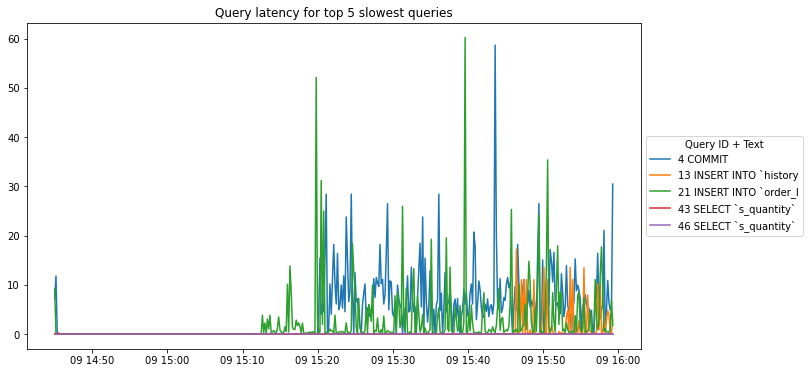

In [81]:
%matplotlib inline
#%matplotlib notebook
style = {'description_width': 'initial'}
layout = widgets.Layout(display='flex',
                align_items='center',
                width='50%')
w1 = widgets.Dropdown(
    options=['---options---','CPU', 'Data IO', 'Log IO', 'Duration', 'Execution Count'],
    value='---options---',
    description='Metric type:',
    style = style,
    layout = layout,
)
w2 = widgets.Dropdown(
    options=['Last 1 hr','Last 6 hrs', 'Last 24 hrs', 'past week', 'past month', 'custom'],
    value='Last 1 hr',
    description='Time Period:',
    style = style,
    layout = layout,
)

plt.figure(1) # CPU
plt.figure(2) # Duration
clear_output(wait = True)
plt.rcParams['figure.figsize'] = [11, 6]
plt.tight_layout()
plt.ion()
def on_change(change):
    #clear_output(wait = True)
    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == 'CPU':
            clear_output(wait = True)
            display(HBox([left_box, right_box]))
            visualize(change['new'])
        elif change['new'] == 'Duration':
            clear_output(wait = True)
            display(HBox([left_box, right_box]))
            visualize(change['new'])
        else:
            print("not_implemented_yet")

w1.observe(on_change)
#w2.observe(on_change)
left_box = w1
right_box = w2
display(HBox([left_box, right_box]))

In [ ]:
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math


fig, axs = plt.subplots(2, figsize=(10, 7))
y1_max=0
y2_max=0
bottom1 = np.zeros(len(all_timestamp))
bottom2 = np.zeros(len(all_timestamp))
def sumzip(*items):
    return [sum(values) for values in zip(*items)]

for query in dict:
    #dict[query].print_digest_query()
    if dict[query].query_id in cpu_top5_qid:
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y1 = np.array(dict[query].cpu_usage, dtype=np.float64)
        #y1_max = max(y1_max, max(y1))
        axs[0].bar(x, y1, width = 0.0001, label=str(dict[query].query_id) + " "+ dict[query].digest_text[:20], bottom = bottom1)
        print(dict[query].query_id)
        #print(x)
        #print(y1)
        bottom1 = y1 + bottom1


    if dict[query].query_id in time_top5_qid:
        qid=dict[query].query_id
        x = all_timestamp#[dt.datetime.strptime(d,'%Y%m%d_%H%M%S') for d in all_timestamp]#dict[query].timestamp]
        y2 = np.array(dict[query].time_ms, dtype=np.float64)
        print(dict[query].query_id)
        #print(x)
        #print(y2)
        
        axs[1].bar(x, y2, width = 0.0001, label=str(dict[query].query_id)+ " " + dict[query].digest_text[:20], bottom = bottom2)
        #y2_max = max(y2_max, max(y2))
        bottom2 = y2 + bottom2
    


axs[0].set_yticks(np.linspace(0,max(bottom1),10))
axs[0].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[0].set_title("CPU usage per query for queries with top 5 CPU usage")
axs[1].set_yticks(np.linspace(0,max(bottom2),10))
axs[1].legend(title = "Query ID + Text", loc=6, bbox_to_anchor=(1, 0.5))
axs[1].set_title("Query latency for top 5 slowest queries")


plt.tight_layout()

#plt.legend()
plt.show()


In [ ]:
list1 = dict_by_id[44].time_ms

list2 = [(list1[i]+list1[i+1])/2 for i in range(len(list1)) if i%2==0 and len(list1)>i+1] # 2배로 rollup
print(list1)
print(list2)
print(len(list1), len(list2))

list4 = [(list2[i]+list2[i+1])/2 for i in range(len(list2)) if i%2==0 and len(list2)>i+1] # 4배로 rollup

print(list4)
print(len(list4))

# n배 rollup하는법
# x by n 으로 reshape한다
# 1234
# 5678 2 by 4
# 행을 평균낸다?


In [ ]:
#easy rollup

a = np.arange(13)
p = 5
a = np.append(a,np.zeros(p-len(a)%p))

a=a.reshape(p,int(len(a)/p))
a.mean(axis=1)

In [ ]:
import subprocess

# proc = subprocess.Popen(
#     ['ps -ef | grep mysql'],
#     stdout=subprocess.PIPE
#     )
# out, err = proc.communicate()
# print(out)
# print(out.decode('utf-8'))

ps_result = subprocess.check_output(['ps -ef | grep mysql'], shell=True).decode()


ps_lines = ps_result.splitlines()
TID = []
for ps_line in ps_lines:
    ps_line=ps_line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
    ps = ps_line.split(' ')
    if 'mysql' in ps[0]:
        TID.append(ps[1])

print(TID)
# result = subprocess.check_output(['pidstat', '-t']).decode()
# #len (result.splitlines()) 
# result.splitlines()
# lines = result.splitlines()[3:]
# dict={}
# for line in lines:
#     line=line.replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ').replace("  ",' ')
#     words = line.split(' ')
#     # TID = words[3]
#     # %cpu = words[8]
#     if words[3] =='-':
#         continue
#     dict[words[3]] = words[8]

# sorted(dict.items(),key=lambda x:x[1],reverse=True)


In [ ]:
# Interactive Mode

%matplotlib notebook

# Import Library


import numpy as np
import time
import matplotlib.pyplot as plt

# Create subplots

figure, ax = plt.subplots(figsize=(4,5))

# Data Coordinates

x = np.linspace(0, 20, 80)
y = np.sin(x)

# GUI

plt.ion()

#  Plot

plot1, = ax.plot(x, y)

# Labels

plt.xlabel("X-Axis",fontsize=18)
plt.ylabel("Y-Axis",fontsize=18)

for value in range(150):
    update_y_value = np.sin(x-2.5*value)
    
    plot1.set_xdata(x)
    plot1.set_ydata(update_y_value)
    
    figure.canvas.draw()
    figure.canvas.flush_events()
    time.sleep(0.1)


# Display

#plt.show()